PACKAGES

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import itertools

from cleantext import clean
import nltk
from nltk.tokenize import word_tokenize 
from nltk.tokenize import sent_tokenize 
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import *

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marku\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marku\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CLEANING, TOKENIZING, STOPWORDS AND STEMMING

In [3]:
####################################### CLEANING ######################################
def cleaningTime(x):
    if isinstance(x, str):
        clean_text = x.replace('|', '')
        clean_text = clean_text.replace('+', '')
        clean_text = clean_text.replace('$', '')
        
        regex = r'\b[xX]+\b' # remove all strings of x's and X's
        regex2 = r'[=]+'
        clean_text = re.sub(regex, '', clean_text)
        clean_text = re.sub(regex2, '', clean_text)
        clean_text = re.sub('<', ' ', clean_text)
        clean_text = re.sub('>', ' ', clean_text)
        
        clean_text = re.sub(r'\d{1,2}\/\d{1,2}\/\d{2,4}', '<DATE>', clean_text)
        
        clean_text = clean(clean_text,
            no_punct=True,
            lower=True,                    # lowercase text
            no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
            no_urls=True,                  # replace all URLs with a special token
            no_emails=True,                # replace all email addresses with a special token
            no_numbers=True,
            replace_with_url="<URL>",
            replace_with_email="<EMAIL>",
            replace_with_number="<NUMBER>",
            )
        clean_text = re.sub(r"[^a-zA-Z0-9]+", ' ', clean_text) # remove all non-alphanumeric characters
        return clean_text
    else:
        return ''

####################################### TOKENIZE #########################################
def Tokenize(x):     
    tokens = nltk.word_tokenize(x)
    return tokens

######################################## REMOVING STOPWORDS ################################
stop_words = set(stopwords.words('english'))

# removing
def Remove_stopwords(x): 
    filtered_sentence = []
    for w in x:
        if w not in stop_words:
            filtered_sentence.append(w)
    return filtered_sentence

######################################### STEMMING ##########################################
stemmer = SnowballStemmer("english")

def Stemming_Words(x):
    stem_words = []
    for w in x:
        word = stemmer.stem(w)
        stem_words.append(word)
    return stem_words

######################################## COUNTING WORDS #####################################
def unique_words (file):
    UN = {}
    for row in file:
        for word in row:
            if word not in UN:
                UN[word] = 1
            else: 
                UN[word] += 1
    UN = dict(sorted(UN.items(), key = lambda kv: kv[1], reverse=True)) # Sorting the unique words after number of occurrences, from highest to lowest
    return UN

CLEANING FAKENEWSCORPUS SAMPLE

In [4]:
R = pd.read_csv("https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv") 
Copy_clean = R.copy() 

Copy_clean['content'] = R['content'].apply(cleaningTime)

Copy_tok = Copy_clean.copy()
Copy_tok['content'] = Copy_tok['content'].apply(Tokenize)
#print(Copy_tok['content'])

Copy_stop = Copy_tok.copy()
Copy_stop['content'] = Copy_stop['content'].apply(Remove_stopwords)

Copy_stemming = Copy_stop.copy()
Copy_stemming['content'] = Copy_stemming['content'].apply(Stemming_Words)

# number of unique words after...
print("Number of unique words after tokenization: ", len(unique_words(Copy_tok['content'])))
print("Number of unique words after removing stopwords: ", len(unique_words(Copy_stop['content'])))
print("Number of unique words after stemming: ", len(unique_words(Copy_stemming['content'])))

# reductionrates
print("Reduction of UW from tokenization to after removing stopwords (in %): ", 100 - (len(unique_words(Copy_stop['content']))/len(unique_words(Copy_tok['content'])))*100)
print("Reduction of UW from stopwords to after stemming (in %): ", 100 - (len(unique_words(Copy_stemming['content']))/len(unique_words(Copy_stop['content'])))*100)

Number of unique words after tokenization:  16589
Number of unique words after removing stopwords:  16457
Number of unique words after stemming:  10936
Reduction of UW from tokenization to after removing stopwords (in %):  0.7957079992766296
Reduction of UW from stopwords to after stemming (in %):  33.54803427113082


<h3> FakeNews Sample exploration

In [5]:
# TRUMP AND FAKE NEWS
# number of the use of the word 'trump' for every type of news
#print("Number of the use of the word 'trump' for every type of news: ")
#print(Copy_stemming['content'].astype(str).str.count('trump').groupby(Copy_stemming['type']).sum())

#print("% of the use of the word 'trump' in fake news articles: ")
#print(Copy_stemming['content'].astype(str).str.count('trump').groupby(Copy_stemming['type']).sum()['fake']/Copy_stemming['content'].astype(str).str.count('trump').sum()*100)

# DISTRIBUTION OF THE NUMBER OF ARTICLES FOR EVERY TYPE OF NEWS IN DATASET
print("Number of articles for every type of news: ")
print(Copy_stemming['content'].astype(str).groupby(Copy_stemming['type']).count())

print("_______________________________")
# AUTHOR OF ARTICLES OF ONE TYPE OF NEWS AND HOW MANY THEY HAVE WRITTEN
def Authors (news_type): 
    p = {}
    for i in range(len(Copy_stemming['type'])):
        if Copy_stemming['type'][i] == news_type:
            if Copy_stemming['authors'][i] not in p:
                # put it in the dictionary
                p[Copy_stemming['authors'][i]] = 1
            else:
                # increment the counter
                p[Copy_stemming['authors'][i]] += 1
    return dict(sorted(p.items(), key = lambda kv: kv[1], reverse=True))

print("Author of articles of type 'fake' and how many they have written: ")
print(Authors('fake'))

# how many articles has author 'John Rolls'
print("How many articles has author 'John Rolls': ")
print(Copy_stemming['content'].astype(str).groupby(Copy_stemming['authors']).count()['John Rolls'])

print("_______________________________")
# DOMAIN OF THE ARTICLES OF EACH TYPE OF NEWS
def domains(newstype):
    k = {}
    for i in range(len(Copy_stemming['type'])):
        if Copy_stemming['type'][i] == newstype:
            if Copy_stemming['domain'][i] not in k:
                # put it in the dictionary
                k[Copy_stemming['domain'][i]] = 1
            else:
                # increment the counter
                k[Copy_stemming['domain'][i]] += 1
    return k

## AVERAGE NUMBER OF WORDS IN THE ARTICLES OF EACH TYPE OF NEWS
def average_wordcounts(newstype):
    n = []
    for i in range(len(Copy_stemming['type'])):
        if Copy_stemming['type'][i] == newstype:
            n.append(len(Copy_stemming['content'][i]))
    return (sum(n)/len(n))

Av_wordcount_conspiracy = average_wordcounts('conspiracy') #462.42 words
Av_wordcount_reliable = average_wordcounts('reliable') #256.7 words
Av_wordcount_fake = average_wordcounts('fake') #376.75 words
Av_wordcount_unreliable = average_wordcounts('unreliable') #180.0 words
Av_wordcount_junksci = average_wordcounts('junksci') #218.7 words
Av_wordcount_bias = average_wordcounts('bias') #256.7 words
Av_wordcount_political = average_wordcounts('political') #367.69 words
Av_wordcount_unknown = average_wordcounts('unknown') 
Av_wordcount_hate = 0 
Av_wordcount_rumor = 0

# 'fake', 'conspiracy', 'junksci', 'hate', 'unreliable', 'rumor'
fake = (Av_wordcount_fake + Av_wordcount_conspiracy + Av_wordcount_junksci + Av_wordcount_unreliable)/4
non_fake = (Av_wordcount_reliable + Av_wordcount_bias + Av_wordcount_political)/3

Number of articles for every type of news: 
type
bias            6
clickbait       1
conspiracy     31
fake          155
hate            1
junksci         6
political      23
reliable        3
unknown         6
unreliable      6
Name: content, dtype: int64
_______________________________
Author of articles of type 'fake' and how many they have written: 
{nan: 51, 'John Rolls': 10, 'Morgan Linton': 6, 'The Daily Sheeple': 6, 'Lisa Haven': 4, 'Marler Blog': 4, 'Freedom Bunker': 3, 'Alton Parrish': 3, 'Shahzaib Elahi': 3, 'Psychic Focus': 3, "Caroline'S Breast Cancer Blog": 3, 'Universe Today': 2, 'Downsize Dc': 2, 'Wake Up World': 2, 'B Mans Revolt': 2, 'Due Diligence': 2, 'Ufo Iconoclast': 2, 'Earth Heal': 2, 'Norml Foundation': 2, 'Mercedes Kirkel': 2, "A Bad Witch'S Blog": 2, 'James Rathey': 2, 'The Conglomerate': 2, 'Zurich Times': 1, 'Cna Daily News - Europe': 1, 'Baroness Photos': 1, 'Pawan Kadu': 1, 'Michael Johnston': 1, 'Judicial Watch': 1, 'Cop Block': 1, 'Alpha Sources': 1, 'D

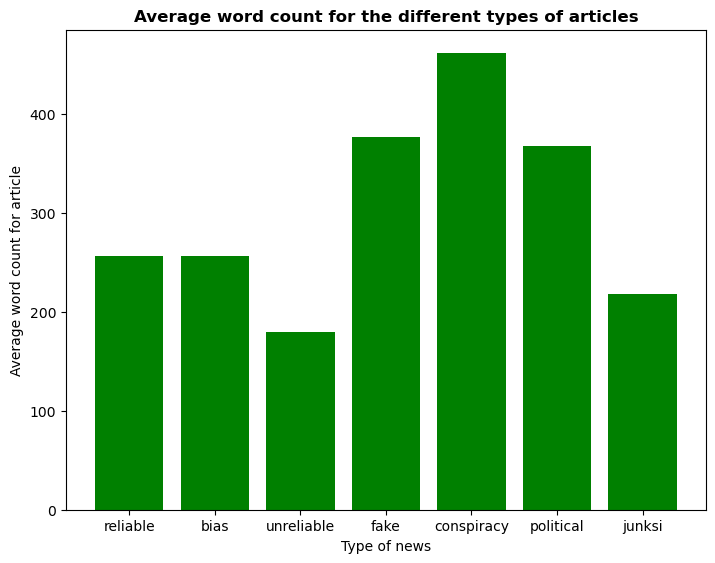

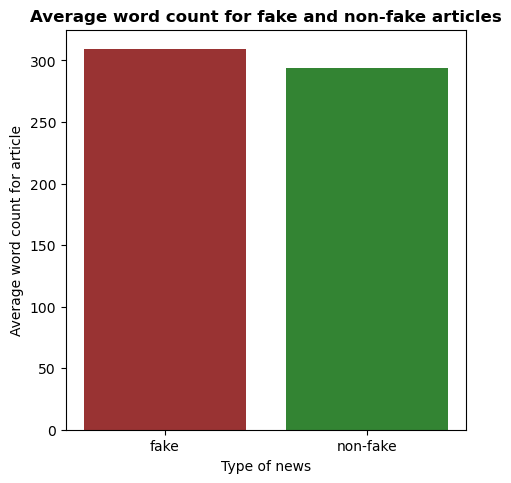

In [6]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
type_news = ['reliable', 'bias', 'unreliable', 'fake', 'conspiracy', 'political', 'junksi']
average_wordcount = [256.7, 256.7, 180.0, 376.75, 462.42, 367.69, 218.7]

ax.set_title('Average word count for the different types of articles', fontsize=12, fontweight='bold') # title
ax.set_ylabel('Average word count for article') # y-axis label
ax.set_xlabel('Type of news') # x-axis label
ax.bar(type_news, average_wordcount, color=['green'])
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
type_news = ['fake', 'non-fake']
average_wordcount = [fake, non_fake]

ax.set_title('Average word count for fake and non-fake articles', fontsize=12, fontweight='bold') # title
ax.set_ylabel('Average word count for article') # y-axis label
ax.set_xlabel('Type of news') # x-axis label

ax.bar(type_news, average_wordcount, color=[(0.5, 0, 0, 0.8), (0, 0.4, 0, 0.8)])
fig.set_size_inches(4, 4)
plt.show()

PLOTS/COUNTS

{'number': 2453, 'url': 243, 'email': 104, 'date': 27}


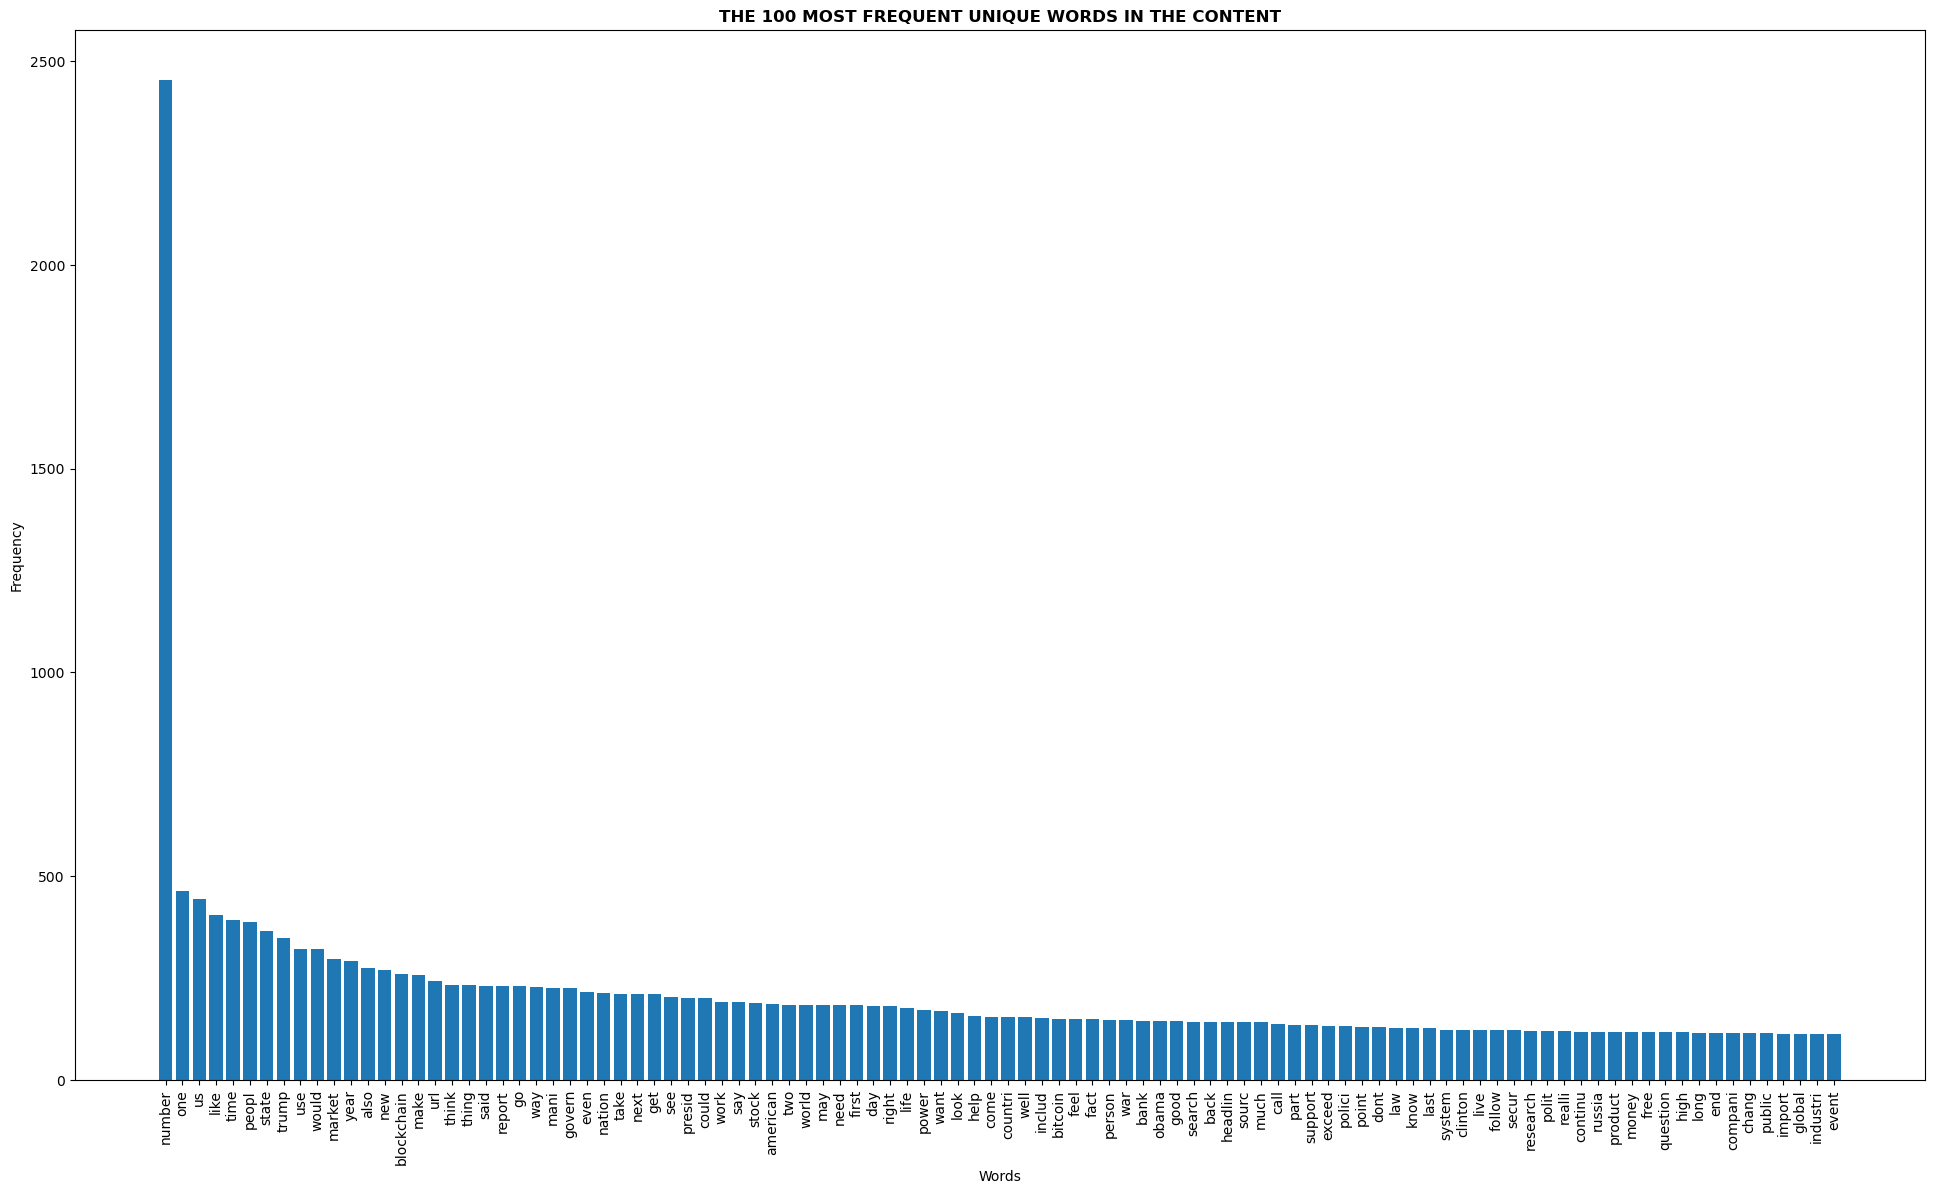

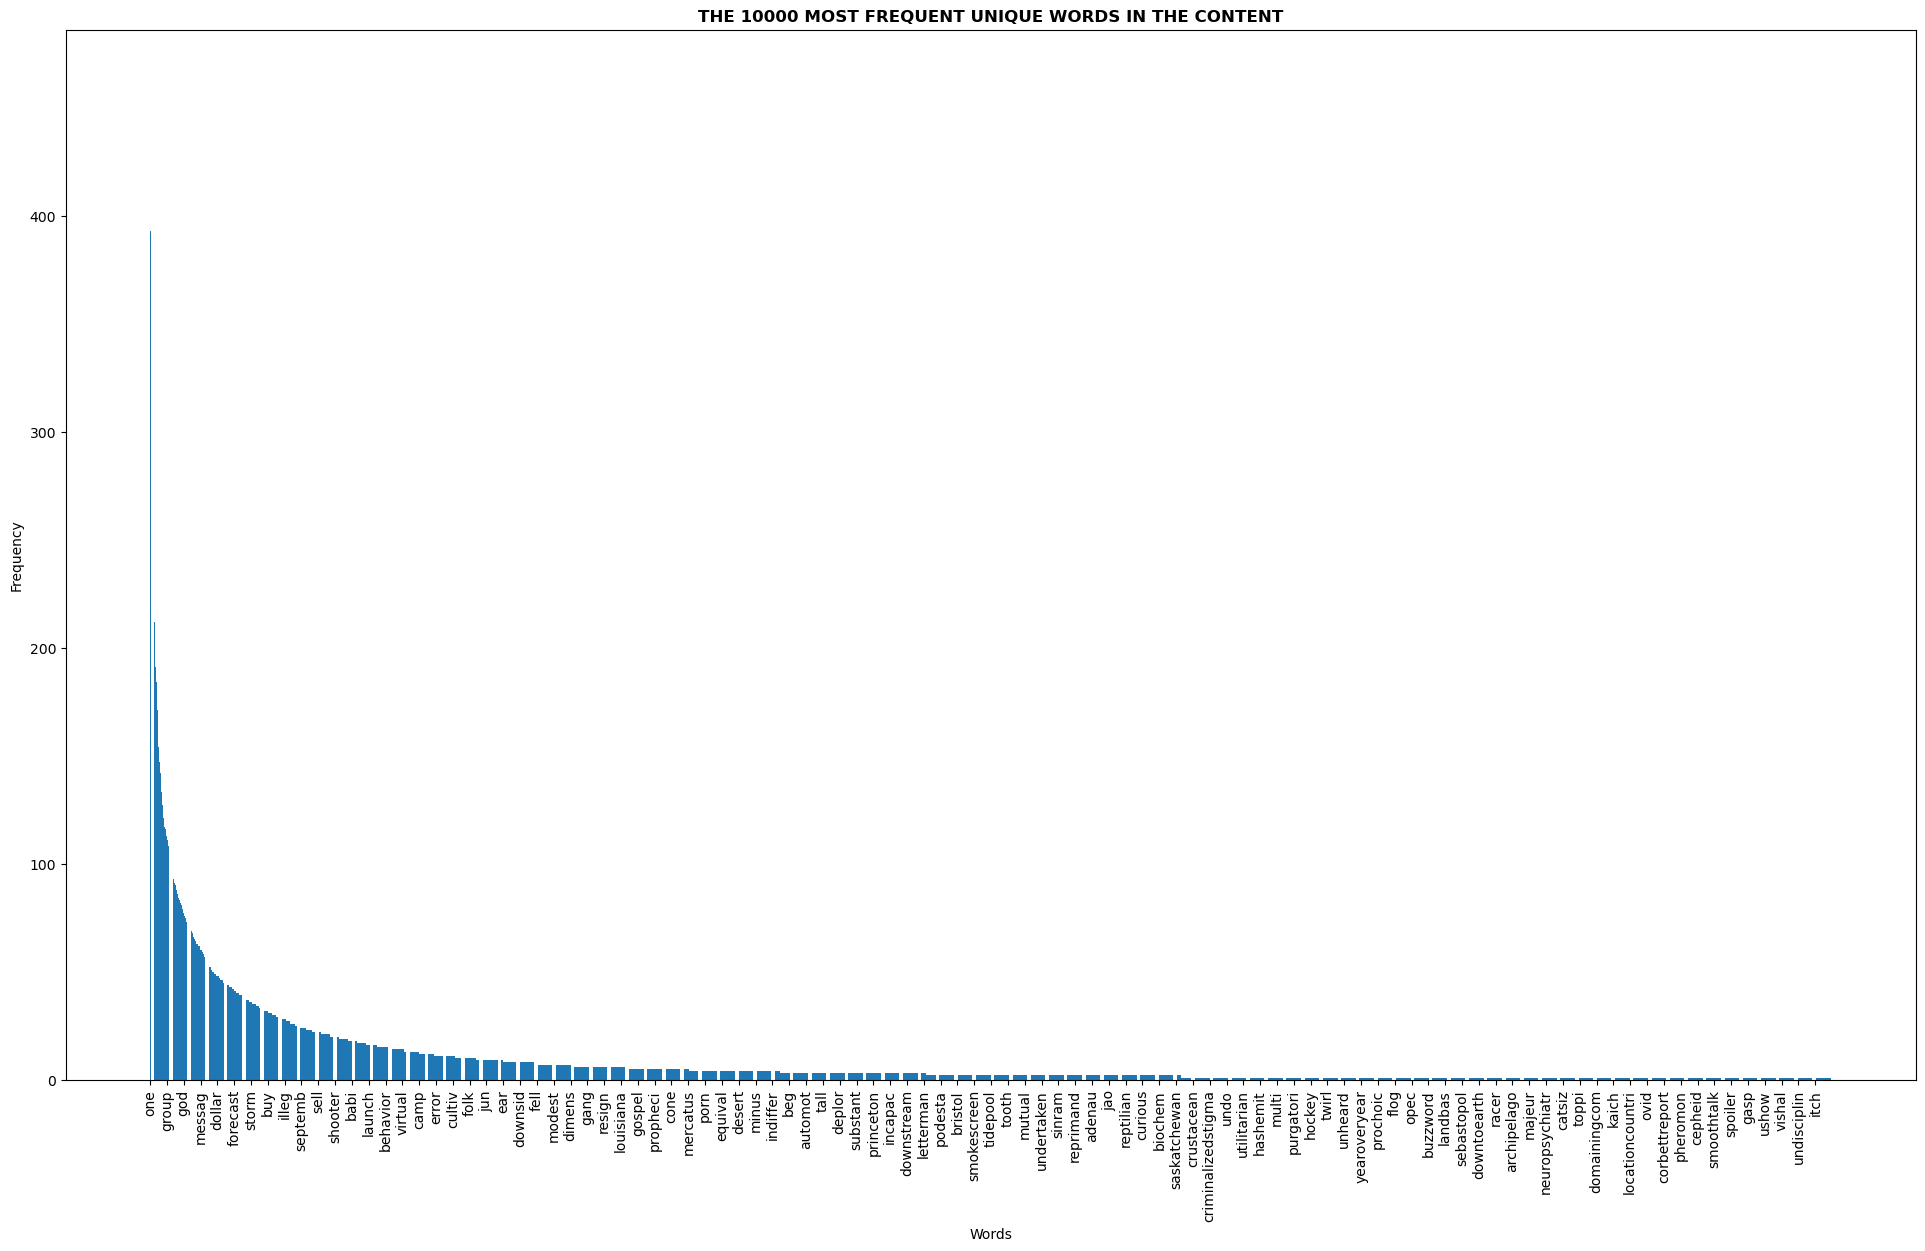

In [7]:
# COUNTING
count = 0 
wordlist = ['url', 'number', 'email', 'date']
D = {}
for i in Copy_stemming['content']:
    for x in i:
        if x in wordlist and x not in D:
            D[x] = 1
        elif x in wordlist and x in D:
            D[x] += 1
        else:
            None            
print(D)

# THE 100 MOST FREQUENT WORDS IN CONTENT
UW_stemming = unique_words(Copy_stemming['content'])
the_hundred = dict(itertools.islice(UW_stemming.items(), 100))

# PLOT
fig = plt.figure()
ax = fig.add_axes([0,0,1,1]) 
words = the_hundred.keys() 
count = the_hundred.values()
ax.bar(words,count)
ax.set_title('THE 100 MOST FREQUENT UNIQUE WORDS IN THE CONTENT', fontsize=12, fontweight='bold') # title
ax.set_xlabel('Words') # x-axis label
ax.set_ylabel('Frequency') # y-axis label
plt.xticks(rotation= 'vertical')
fig.set_size_inches(18.5, 10.5) # size of the plot
plt.show()

# THE 10000 MOST FREQUENT WORDS IN CONTENT
the_tenthousand = dict(itertools.islice(UW_stemming.items(), 10000))
del the_tenthousand['number'] # deleting the word 'number' from the dictionary

# PLOT
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
words = the_tenthousand.keys()
count = the_tenthousand.values()
ax.bar(words,count)
ax.set_title('THE 10000 MOST FREQUENT UNIQUE WORDS IN THE CONTENT', fontsize=12, fontweight='bold') # title
ax.set_xlabel('Words') # x-axis label
ax.set_ylabel('Frequency') # y-axis label
plt.xticks(range(0, 10000, 100), list(the_tenthousand.keys())[::100], rotation='vertical') # x-axis labels every 100 words
fig.set_size_inches(18.5, 10.5) # size of the plot
plt.show()

LOADING 2 MILLION ARTICLES INTO A CSV FILE

In [ ]:
# Read the first 2000000 rows in chunks of 10000, and write to a csv file called 2mio-raw.csv. Include progress bar (tqdm).
chunksize = 10000
filename = 'news_cleaned_2018_02_13.csv'
output_file = '2mio-raw.csv'

tqdm.pandas()

for i, chunk in enumerate(pd.read_csv(filename, chunksize=chunksize, lineterminator='\n')):
    try:
        print('Processing chunk', i+1)
        if i == 0:
            chunk.to_csv(output_file, index=False)
        else:
            chunk.to_csv(output_file, index=False, header=False, mode='a')
        if chunksize*(i+1) >= 2000000:
            break

    except:
        print('Error in chunk', i+1)
        pass

    tqdm.write(f"{chunksize*(i+1)} rows processed. The total number of articles remaining is {2000000 - chunksize*(i+1)}")

APPLYING CLEANING, TOKENIZING, STOPWORDS AND STEMMING TO 2 MILLION ARTICLES

In [ ]:
chunksize = 10000
filename = '2mio-raw.csv'
output_file = 'df_clean_tok_stop_stem.csv'

tqdm.pandas()

for i, chunk in enumerate(pd.read_csv(filename, chunksize=chunksize)):
    print('Processing chunk', i+1)
    chunk['content'] = chunk['content'].apply(cleaningTime).apply(Tokenize).apply(Remove_stopwords).apply(Stemming_Words)
    if i == 0:
        chunk.to_csv(output_file, index=False)
    else:
        chunk.to_csv(output_file, index=False, header=False, mode='a')
    
    tqdm.write(f"{chunksize*(i+1)} rows processed. The total number of articles remaining is {2000000 - chunksize*(i+1)}")

LOAD THE 2 MILLION ARTICLES INTO A PANDAS DATAFRAME

In [13]:
df = pd.read_csv('df_clean_tok_stop_stem.csv', usecols=['content', 'type', 'title'])
df

C:\Users\marku\AppData\Local\Temp\ipykernel_4872\2464543508.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('df_clean_tok_stop_stem.csv', usecols=['content', 'type', 'title'])


,type,content,title
0,rumor,"['life', 'illus', 'least', 'quantum', 'level',...",Is life an ILLUSION? Researchers prove 'realit...
1,hate,"['unfortun', 'hasnt', 'yet', 'attack', 'islam'...",Donald Trump
2,hate,"['los', 'angel', 'polic', 'depart', 'deni', 'n...",Donald Trump
3,hate,"['white', 'hous', 'decid', 'quiet', 'withdraw'...","MORE WINNING! Israeli intelligence source, DEB..."
4,hate,"['time', 'come', 'cut', 'tongu', 'support', 'p...","“Oh, Trump, you coward, you just wait, we will..."
...,...,...,...
1999995,unknown,"['emili', 'keeler', 'found', 'curat', 'million...",Emily Keeler
1999996,unknown,"['new', 'inquiri', 'new', 'inquiri', 'space', ...",Chloe Wyma
1999997,bias,"['eric', 'london', 'wide', 'rang', 'nomin', 'l...",Defend Democracy Press
1999998,unknown,"['given', 'choic', 'white', 'black', 'could', ...","In a Mirror, Darkly"


MORE PREPROCESSING ON THE DATAFRAME

In [14]:
# Remove articles with missing 'type' values
df = df[df['type'].notna()]

# Remove articles with 'type' values = 'unknown'
df = df[df['type'] != 'unknown']

# Print number of duplicates
print("Number of duplicates: ", df.duplicated(subset=['title', 'content']).sum())

# Remove duplicate articles based on 'title' and 'content' columns
df.drop_duplicates(subset=['title', 'content'], inplace=True)

# Print sum of articles for all types
print("Total # of articles: ", df['type'].value_counts().sum())

# Make a new column 'label' and assign 1 to all rows with 'type' = 'fake' or 'conspiracy' or 'junksci' or 'hate' or 'unreliable' or 'rumor' and 0 to all other rows
df['label'] = df['type'].apply(lambda x: 1 if x in ['fake', 'conspiracy', 'junksci', 'hate', 'unreliable', 'rumor'] else 0)

Number of duplicates:  196910
Total # of articles:  1551227


TRAIN, TEST AND VALIDATION SPLIT

In [15]:
# Assign X and y
X = df['content']
y = df['label']

# Split into train test and validation with 80 10 10 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

TD-IDF VECTORIZER

In [17]:
# Use TF-IDF to transform the data
tfidf_transformer = TfidfVectorizer()

# Fit the transformer on the training set
X_train_tfidf = tfidf_transformer.fit_transform(X_train)

# Fit the transformer on the validation set
X_val_tfidf = tfidf_transformer.transform(X_val)

# Fit the transformer on the test set
X_test_tfidf = tfidf_transformer.transform(X_test)

<h2> Models (baseline)

LOGISTIC REGRESSION

In [19]:
# Train a logistic regression model on the training set
LogRegFinal = LogisticRegression(random_state=0, solver='lbfgs', max_iter=2000)

# Fit the model on the training set
LogRegFinal.fit(X_train_tfidf, y_train)

# Predict the labels of the validation set
y_pred = LogRegFinal.predict(X_val_tfidf)

# Print the accuracy score
print("Accuracy score (logistic): ", accuracy_score(y_val, y_pred))

# Print the classification report
classification_report(y_val, y_pred)
print("Classification report (logistic): ", classification_report(y_val, y_pred))

Accuracy score (logistic):  0.9017618277109133
Classification report (logistic):                precision    recall  f1-score   support

           0       0.88      0.93      0.91     79839
           1       0.92      0.87      0.90     75284

    accuracy                           0.90    155123
   macro avg       0.90      0.90      0.90    155123
weighted avg       0.90      0.90      0.90    155123



LOGISTIC REGRESSION (test set)

In [20]:
# Predict the labels of the test set
y_pred = LogRegFinal.predict(X_test_tfidf)

# Print the accuracy score
print("Accuracy score (logistic test set): ", accuracy_score(y_test, y_pred))

# Print the classification report
classification_report(y_test, y_pred)
print("Classification report (logistic test set): ", classification_report(y_test, y_pred))

Accuracy score (logistic test set):  0.9037151163915087
Classification report (logistic test set):                precision    recall  f1-score   support

           0       0.89      0.93      0.91     80249
           1       0.92      0.87      0.90     74874

    accuracy                           0.90    155123
   macro avg       0.91      0.90      0.90    155123
weighted avg       0.90      0.90      0.90    155123



CONFUSION MATRIX (Logistic Regression)

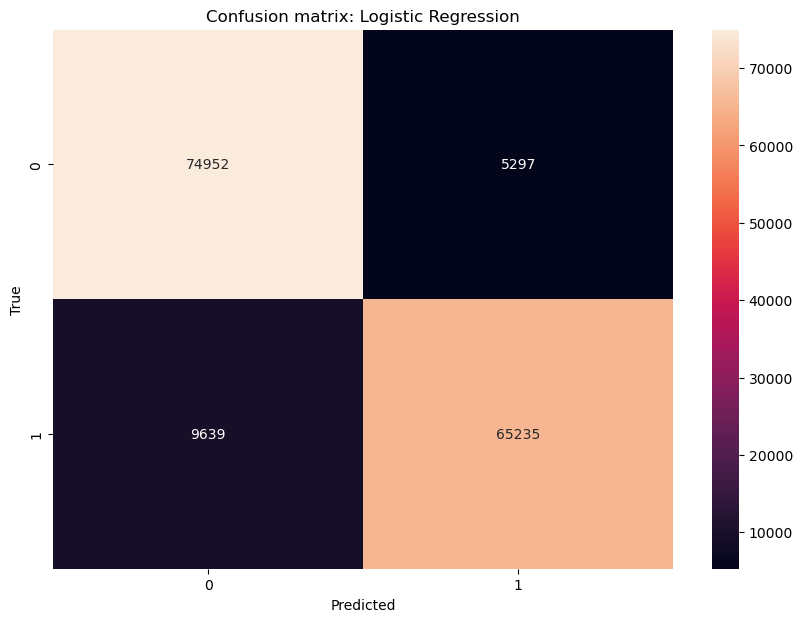

In [21]:
# Plot confusion matrix for logistic regression model on test set
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix: Logistic Regression')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

NAIVE BAYES CLASSIFIER

In [22]:
# Train a multinomial naive bayes model on the training set
clf = MultinomialNB().fit(X_train_tfidf, y_train)

# Predict the labels for the validation set
predicted = clf.predict(X_val_tfidf)

# Calculate the accuracy of the model
accuracy_score(y_val, predicted)
print("Accuracy (naive bayes): ", accuracy_score(y_val, predicted))

# Print the classification report
classification_report(y_val, predicted)
print("Classification report (naive bayes): ", classification_report(y_val, predicted))

Accuracy (naive bayes):  0.8096284883608491
Classification report (naive bayes):                precision    recall  f1-score   support

           0       0.74      0.96      0.84     79839
           1       0.94      0.65      0.77     75284

    accuracy                           0.81    155123
   macro avg       0.84      0.81      0.80    155123
weighted avg       0.84      0.81      0.80    155123



NAIVE BAYES CLASSIFIER (test set)

In [23]:
# Predict the labels for the test set
predicted = clf.predict(X_test_tfidf)

# Calculate the accuracy of the model
accuracy_score(y_test, predicted)
print("Accuracy (naive bayes test set): ", accuracy_score(y_test, predicted))

# Print the classification report
classification_report(y_test, predicted)
print("Classification report (naive bayes test set): ", classification_report(y_test, predicted))

Accuracy (naive bayes test set):  0.8113754891279823
Classification report (naive bayes test set):                precision    recall  f1-score   support

           0       0.75      0.96      0.84     80249
           1       0.94      0.65      0.77     74874

    accuracy                           0.81    155123
   macro avg       0.84      0.81      0.80    155123
weighted avg       0.84      0.81      0.81    155123



CONFUSION MATRIX (Naive Bayes)

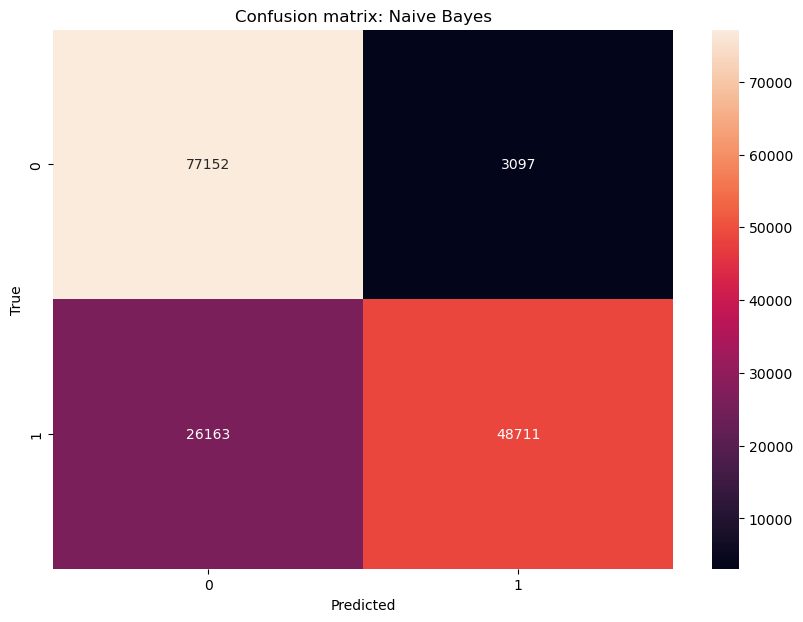

In [24]:
# Plot confusion matrix for naive bayes model on test set
cm = confusion_matrix(y_test, predicted)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix: Naive Bayes')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

<h3> Models (advanced)

SUPPORT VECTOR MACHINE - Linear Support Vector Classification

In [25]:
# Train a linear support vector machine model on the training set
svm = LinearSVC(random_state=0).fit(X_train_tfidf, y_train)

# Predict the labels for the validation set
predicted = svm.predict(X_val_tfidf)

# Calculate the accuracy of the model
accuracy_score(y_val, predicted)
print("Accuracy (svm): ", accuracy_score(y_val, predicted))

# Print the classification report
classification_report(y_val, predicted)
print("Classification report (svm): ", classification_report(y_val, predicted))

Accuracy (svm):  0.9112059462491056
Classification report (svm):                precision    recall  f1-score   support

           0       0.89      0.94      0.92     79839
           1       0.93      0.88      0.91     75284

    accuracy                           0.91    155123
   macro avg       0.91      0.91      0.91    155123
weighted avg       0.91      0.91      0.91    155123



SUPPORT VECTOR MACHINE - Linear Support Vector Classification (test set)

In [26]:
# Predict the labels of the test set
y_pred = svm.predict(X_test_tfidf)

# Print the accuracy score
print("Accuracy score (svm test set): ", accuracy_score(y_test, y_pred))

# Print the classification report
classification_report(y_test, y_pred)
print("Classification report (svm test set): ", classification_report(y_test, y_pred))

Accuracy score (svm test set):  0.9125597106812013
Classification report (svm test set):                precision    recall  f1-score   support

           0       0.90      0.94      0.92     80249
           1       0.93      0.88      0.91     74874

    accuracy                           0.91    155123
   macro avg       0.91      0.91      0.91    155123
weighted avg       0.91      0.91      0.91    155123



CONFUSION MATRIX (SVM)

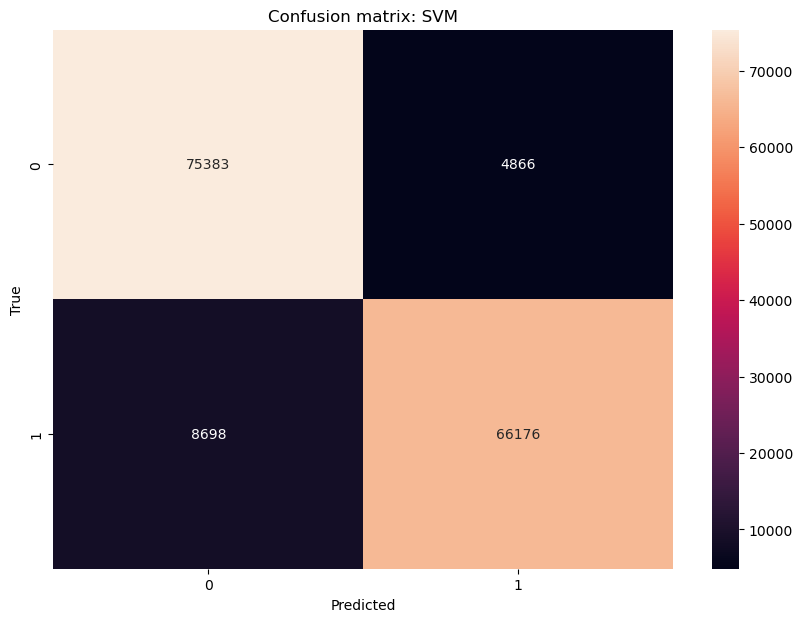

In [27]:
# Plot confusion matrix for svm model on test set
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix: SVM')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

<h3> LIAR Dataset

LOADING LIAR DATASET AND LABEL GROUPING

In [28]:
# Load test.tsv file
dftsv = pd.read_csv('test.tsv', sep='\t', header=None)

# new colomn for the label of the article
dftsv['label'] = dftsv[1].apply(lambda x: 1 if x in ['false', 'pants-fire', 'barely-true'] else 0)

CLEANING, TOKENIZING, STOPWORDS AND STEMMING FOR LIAR DATASET

In [29]:
dftsv[2] = dftsv[2].astype(str)
dftsv[2] = dftsv[2].apply(cleaningTime)
dftsv[2] = dftsv[2].apply(Tokenize)
dftsv[2] = dftsv[2].apply(Remove_stopwords)
dftsv[2] = dftsv[2].apply(Stemming_Words)

VECTORIZE LIAR DATASET

In [30]:
liar_tfidf = tfidf_transformer.transform(dftsv[2].astype(str))

BASELINE MODEL PREDICTIONS

Logistic Regression (LIAR)

In [33]:
# Predict the labels of the test set
y_pred = LogRegFinal.predict(liar_tfidf)

# Print the accuracy score
print("Accuracy score (logistic LIAR): ", accuracy_score(dftsv['label'], y_pred))

# Print the classification report
classification_report(dftsv['label'], y_pred)
print("Classification report (logistic LIAR): ", classification_report(dftsv['label'], y_pred))

Accuracy score (logistic LIAR):  0.5619573796369376
Classification report (logistic LIAR):                precision    recall  f1-score   support

           0       0.57      0.93      0.71       714
           1       0.49      0.08      0.14       553

    accuracy                           0.56      1267
   macro avg       0.53      0.51      0.42      1267
weighted avg       0.53      0.56      0.46      1267



CONFUSION MATRIX (logistic LIAR)

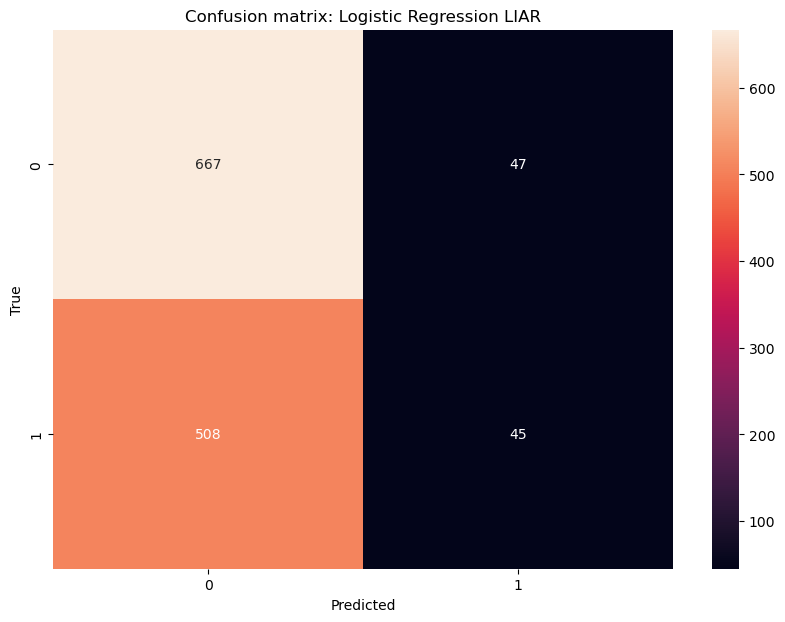

In [34]:
# Plot confusion matrix for logistic regression model on LIAR set
cm = confusion_matrix(dftsv['label'], y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix: Logistic Regression LIAR')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

Naive Bayes Classifier (LIAR)

In [35]:
# Predict the labels of the test set
y_pred = clf.predict(liar_tfidf)

# Print the accuracy score
print("Accuracy score (naive bayes LIAR): ", accuracy_score(dftsv['label'], y_pred))

# Print the classification report
classification_report(dftsv['label'], y_pred)
print("Classification report (naive bayes LIAR): ", classification_report(dftsv['label'], y_pred))

Accuracy score (naive bayes LIAR):  0.5595895816890292
Classification report (naive bayes LIAR):                precision    recall  f1-score   support

           0       0.56      0.96      0.71       714
           1       0.45      0.04      0.07       553

    accuracy                           0.56      1267
   macro avg       0.51      0.50      0.39      1267
weighted avg       0.51      0.56      0.43      1267



CONFUSION MATRIX (Naive Bayes Classifier LIAR)

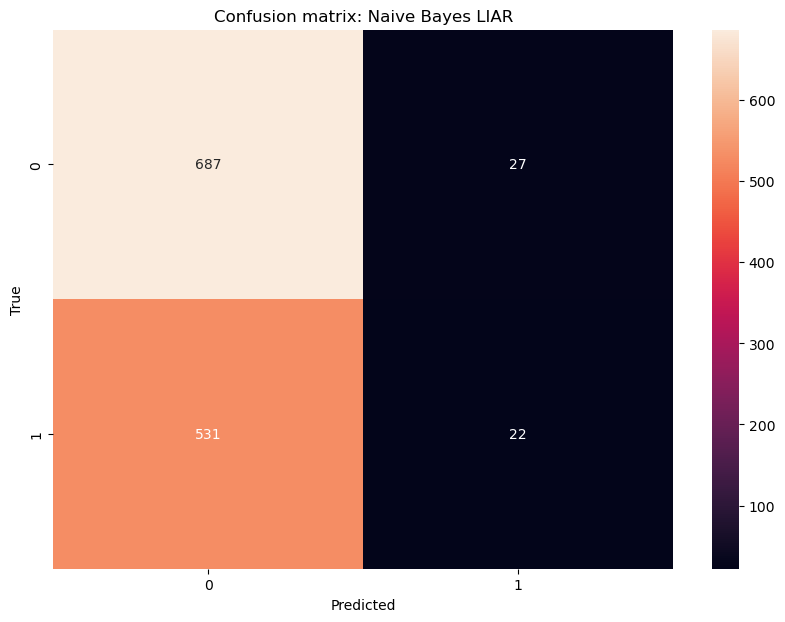

In [36]:
# Plot confusion matrix for naive bayes model on LIAR set
cm = confusion_matrix(dftsv['label'], y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix: Naive Bayes LIAR')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

ADVANCED MODEL PREDICTIONS

In [31]:
# Predict the labels of the test set
y_pred = svm.predict(liar_tfidf)

# Print the accuracy score
print("Accuracy score (svm LIAR): ", accuracy_score(dftsv['label'], y_pred))

# Print the classification report
classification_report(dftsv['label'], y_pred)
print("Classification report (svm LIAR): ", classification_report(dftsv['label'], y_pred))

Accuracy score (svm LIAR):  0.5611681136543015
Classification report (svm LIAR):                precision    recall  f1-score   support

           0       0.57      0.94      0.71       714
           1       0.48      0.07      0.12       553

    accuracy                           0.56      1267
   macro avg       0.52      0.51      0.42      1267
weighted avg       0.53      0.56      0.45      1267



CONFUSION MATRIX (svm LIAR)

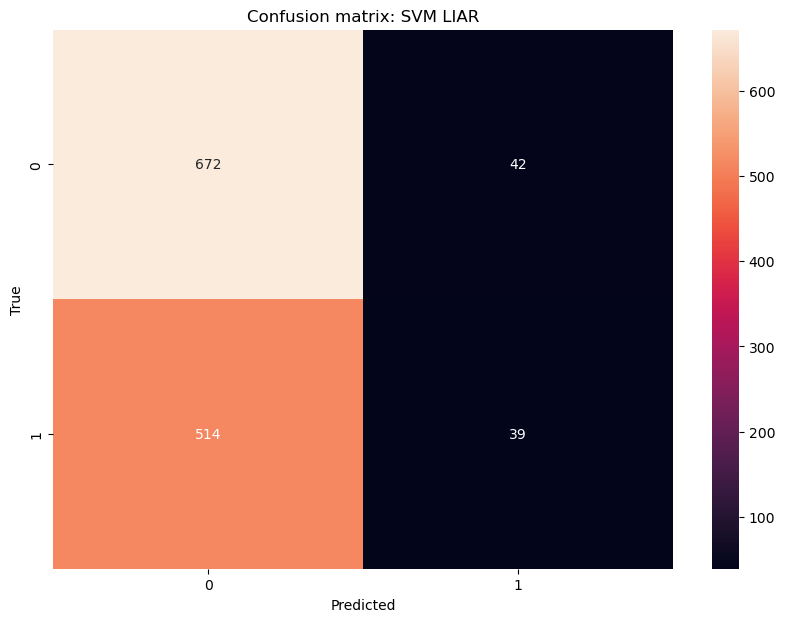

In [32]:
# Plot confusion matrix for svm model on LIAR set
cm = confusion_matrix(dftsv['label'], y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix: SVM LIAR')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()